<a href="https://colab.research.google.com/github/Sreejith-nair511/Summer_course_Ai/blob/main/Transformers_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Part 1: Transformer Encoder from Scratch in PyTorch

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module): # Pytorch which performs Dot Product
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        # Q, K, V: (batch, heads, seq_len, d_k)
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)  # (batch, heads, seq_len, d_k)
        return out, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.linear_Q = nn.Linear(d_model, d_model) # queries
        self.linear_K = nn.Linear(d_model, d_model) # Keys
        self.linear_V = nn.Linear(d_model, d_model) # Values
        self.attn = ScaledDotProductAttention(dropout)
        self.fc = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model) # optional

    def forward(self, x, mask=None):
        bs, seq_len, d_model = x.size()
        # project and split heads
        Q = self.linear_Q(x).view(bs, seq_len, self.num_heads, self.d_k).transpose(1,2)
        K = self.linear_K(x).view(bs, seq_len, self.num_heads, self.d_k).transpose(1,2)
        V = self.linear_V(x).view(bs, seq_len, self.num_heads, self.d_k).transpose(1,2)

        # apply attention
        # Q and K
        # Q, K, and V
        out, attn = self.attn(Q, K, V, mask=mask)

        # concat heads
        out = out.transpose(1,2).contiguous().view(bs, seq_len, d_model)
        out = self.dropout(self.fc(out))
        # residual + norm
        return self.norm(x + out), attn

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.ff = nn.Sequential( # 2 layer neural network with ReLU Activation
            nn.Linear(d_model, d_ff), # W^T . X
            nn.ReLU(), # Activation
            nn.Dropout(dropout), # optional
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.norm = nn.LayerNorm(d_model) # for uniform distribution

    def forward(self, x):
        return self.norm(x + self.ff(x))

class PositionalEncoding(nn.Module): # Positional encoding in pytorch
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div) # Important Words
        pe[:, 1::2] = torch.cos(pos * div) # Less Important Words - Stopwords
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = PositionwiseFeedForward(d_model, d_ff, dropout)

    def forward(self, x, mask=None):
        x, attn = self.self_attn(x, mask)
        x = self.ff(x)
        return x, attn

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, N=6, num_heads=8, d_ff=2048, dropout=0.1, max_len=5000):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, d_model) # You can replace this with Word2Vec, FastText
        # Which is the default embedding model for the torch.
        self.pos_embed = PositionalEncoding(d_model, max_len) # Words (belongs to max len) and word -> dimension)
        # PostionalEmbedding(max_len, dimensions)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(N)
        ])

    def forward(self, src, mask=None):
        # src: (batch, seq_len)
        x = self.token_embed(src) * math.sqrt(self.token_embed.embedding_dim)
        x = self.pos_embed(x)
        attentions = []
        for layer in self.layers:
            x, attn = layer(x, mask)
            attentions.append(attn)
        return x, attentions

# Example usage:
if __name__ == "__main__":
    batch_size, seq_len, vocab_size = 2, 10, 1000
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))
    model = TransformerEncoder(vocab_size)
    out, atts = model(dummy_input)
    print("Output shape:", out.shape)     # (2, 10, 512)
    print("Number of layers’ attention maps:", len(atts))

Output shape: torch.Size([2, 10, 512])
Number of layers’ attention maps: 6




```
# Visualizing BERT’s Attention with HuggingFace + Matplotlib
```



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


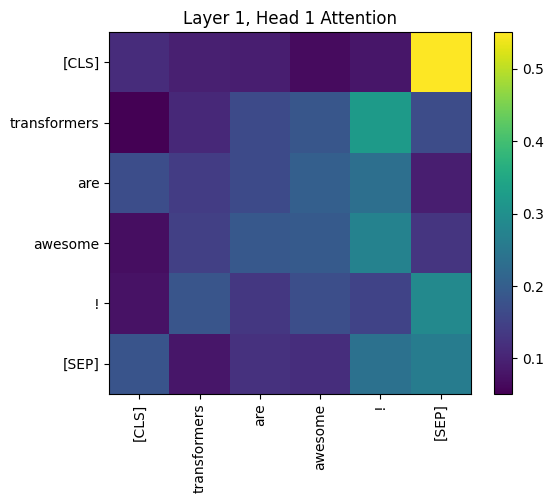

In [ ]:
# Part 2: Visualizing BERT’s Attention with HuggingFace + Matplotlib

import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# 1. Load tokenizer & model (returning attentions)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# 2. Encode text
text = "Transformers are awesome!"
inputs = tokenizer(text, return_tensors='pt')
outputs = model(**inputs)
# outputs.attentions is a tuple: (layer_count, batch, heads, seq_len, seq_len)
attentions = torch.stack(outputs.attentions)  # shape (layers, batch, heads, seq, seq)

# 3. Pick one layer & head to visualize
layer_idx = 0
head_idx = 0
attn_matrix = attentions[layer_idx, 0, head_idx].detach().numpy()

# 4. Plot heatmap
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.figure(figsize=(6, 5))
plt.imshow(attn_matrix, interpolation='nearest')
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title(f"Layer {layer_idx+1}, Head {head_idx+1} Attention")
plt.tight_layout()
plt.show()


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
from tqdm.auto import tqdm

# --- TransformerEncoder from scratch (adapted) ---
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        return torch.matmul(self.dropout(attn), V), attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.attn = ScaledDotProductAttention(dropout)
        self.fc = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, mask=None):
        bs, seq_len, d_model = x.size()
        Q = self.w_q(x).view(bs, seq_len, self.num_heads, self.d_k).transpose(1,2)
        K = self.w_k(x).view(bs, seq_len, self.num_heads, self.d_k).transpose(1,2)
        V = self.w_v(x).view(bs, seq_len, self.num_heads, self.d_k).transpose(1,2)
        out, _ = self.attn(Q, K, V, mask)
        out = out.transpose(1,2).contiguous().view(bs, seq_len, d_model)
        out = self.dropout(self.fc(out))
        return self.norm(x + out)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        return self.norm(x + self.ff(x))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    def forward(self, x, mask=None):
        x = self.self_attn(x, mask)
        x = self.ff(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, N=4, num_heads=4, d_ff=512, dropout=0.1, max_len=512):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(N)
        ])
    def forward(self, src, mask=None):
        x = self.token_embed(src) * math.sqrt(self.token_embed.embedding_dim)
        x = self.pos_embed(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

# --- GLUE Classification Model ---
class GlueTransformer(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super().__init__()
        # small encoder for demo
        self.encoder = TransformerEncoder(vocab_size, d_model=256, N=4, num_heads=4, d_ff=512)
        self.classifier = nn.Linear(256, num_labels)
    def forward(self, input_ids, attention_mask=None):
        # mask for self-attention: allow attend where attention_mask == 1
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(1).unsqueeze(2)  # (bs,1,1,seq)
        else:
            mask = None
        enc_out = self.encoder(input_ids, mask)  # (bs, seq, d_model)
        # simple pooling: use [CLS] at pos 0
        cls_rep = enc_out[:, 0, :]
        logits = self.classifier(cls_rep)
        return logits

# --- Data & Training Setup ---

def collate_fn(batch):
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x['input_ids']) for x in batch], batch_first=True, padding_value=tokenizer.pad_token_id
    )
    attention_mask = (input_ids != tokenizer.pad_token_id).long()
    labels = torch.tensor([x['label'] for x in batch])
    return dict(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

# Choose GLUE task
task = 'sst2'  # sentiment analysis
# QQP: Quora Question Pairs
# MNLI/SNLI: Natural Language Inference
# BOOL, Odd one Out
raw = load_dataset('glue', task)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# Tokenize

def preprocess(example):
    enc = tokenizer(example['sentence'], truncation=True, max_length=128)
    return {'input_ids': enc['input_ids'], 'label': example['label']}

data = raw.map(preprocess)
data.set_format(type='torch', columns=['input_ids', 'label'])

train_loader = DataLoader(data['train'], batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(data['validation'], batch_size=64, collate_fn=collate_fn)

# Instantiate model, optimizer, loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GlueTransformer(tokenizer.vocab_size, num_labels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            preds = logits.argmax(dim=-1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# Training loop
for epoch in range(3):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

    acc = evaluate(valid_loader)
    print(f"Validation Accuracy after epoch {epoch+1}: {acc:.4f}")

print("Training complete.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Epoch 1:   0%|          | 0/2105 [00:00<?, ?it/s]

/tmp/ipython-input-1-3310086790.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(x['input_ids']) for x in batch], batch_first=True, padding_value=tokenizer.pad_token_id


Validation Accuracy after epoch 1: 0.7385


Epoch 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Validation Accuracy after epoch 2: 0.7638


Epoch 3:   0%|          | 0/2105 [00:00<?, ?it/s]

Validation Accuracy after epoch 3: 0.7787
Training complete.


In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl